In [1]:
import pandas as pd
import numpy as np
df = pd.read_csv('S&P500.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-12-30,2251.610107,2253.580078,2233.620117,2238.830078,2238.830078,2671550000
1,2017-01-03,2251.570068,2263.879883,2245.129883,2257.830078,2257.830078,3773010000
2,2017-01-04,2261.600098,2272.820068,2261.600098,2270.750000,2270.750000,3768890000
3,2017-01-05,2268.179932,2271.500000,2260.449951,2269.000000,2269.000000,3785080000
4,2017-01-06,2271.139893,2282.100098,2264.060059,2276.979980,2276.979980,3342080000
...,...,...,...,...,...,...,...
247,2017-12-22,2684.219971,2685.350098,2678.129883,2683.340088,2683.340088,2401030000
248,2017-12-26,2679.090088,2682.739990,2677.959961,2680.500000,2680.500000,1970660000
249,2017-12-27,2682.100098,2685.639893,2678.909912,2682.620117,2682.620117,2202900000
250,2017-12-28,2686.100098,2687.659912,2682.689941,2687.540039,2687.540039,2174890000


In [2]:
# Assuming df is your DataFrame
df['Volatility'] = df['Adj Close'].pct_change().rolling(window=2).std() * 100


In [3]:
volatility  = df[['Date','Volatility']]
import datetime
volatility['Date'] = pd.to_datetime(volatility['Date'])
volatility.set_index('Date', inplace = True)

c:\Users\zc22364\AppData\Local\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


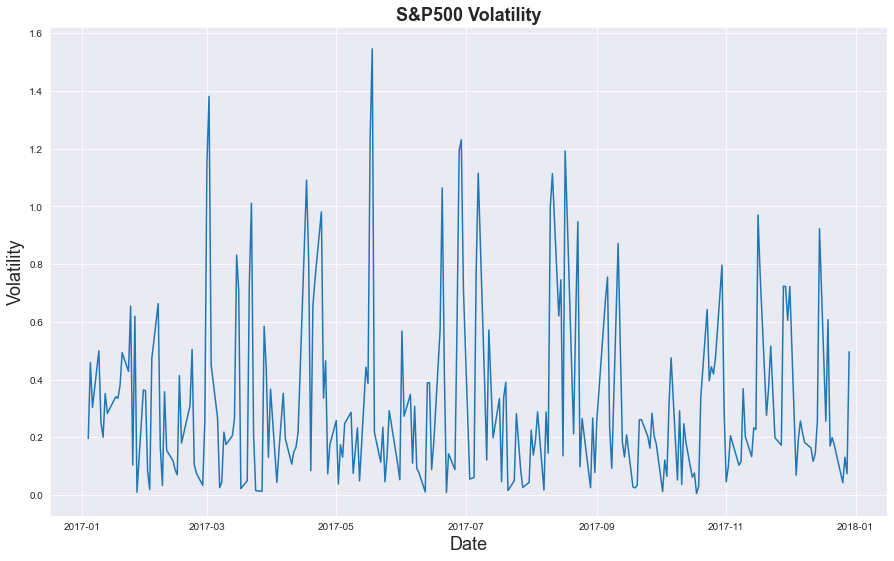

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")
plt.figure(figsize=(15,9))
plt.plot(volatility['Volatility'])
plt.title("S&P500 Volatility", fontsize=18, fontweight='bold')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Volatility', fontsize=18)
plt.show()

In [5]:
close_price = df[['Date','Adj Close']]
close_price['Date'] = pd.to_datetime(close_price['Date'])
close_price.set_index('Date', inplace = True)
close_price.shape

c:\Users\zc22364\AppData\Local\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(252, 1)

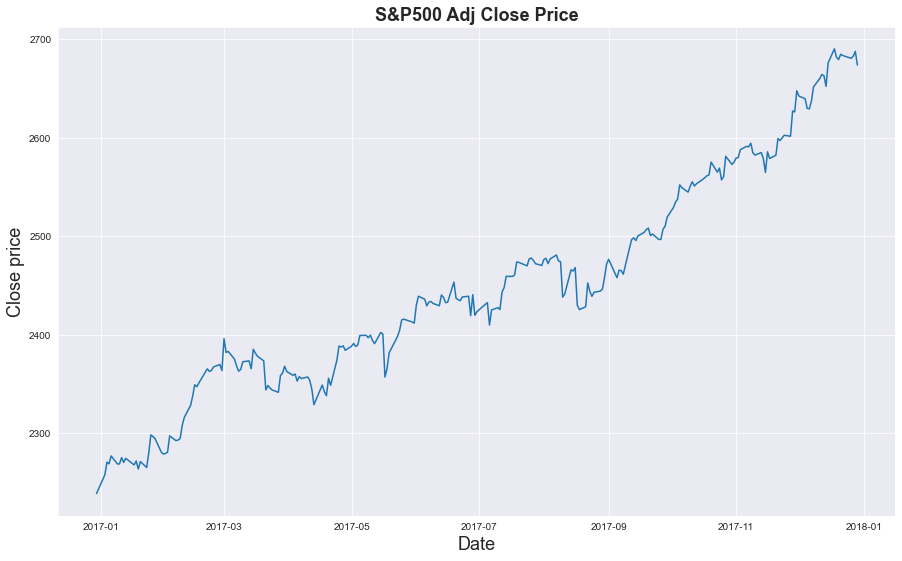

In [6]:
sns.set_style("darkgrid")
plt.figure(figsize=(15,9))
plt.plot(close_price['Adj Close'])
plt.title("S&P500 Adj Close Price", fontsize=18, fontweight='bold')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close price', fontsize=18)
plt.show()

In [7]:
price = df[['Adj Close']]
price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  252 non-null    float64
dtypes: float64(1)
memory usage: 2.1 KB


In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1,1))
price['Adj Close'] = scaler.fit_transform(price['Adj Close'].values.reshape(-1,1))

c:\Users\zc22364\AppData\Local\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy()
    data = []
    for index in range(len(data_raw) - lookback):
        data.append(data_raw[index: index + lookback])
    data = np.array(data)
    test_set_size = int(np.round(0.2 * data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size)
    x_train = data[:train_set_size, :-1, :]
    y_train = data[:train_set_size, -1, :]
    x_test = data[train_set_size:, :-1, :]
    y_test = data[train_set_size:, -1, :]
    return x_train, y_train, x_test, y_test

In [10]:
lookback = 20  # Number of previous days to consider
data = split_data(price, lookback)

In [11]:
x_train, y_train, x_test, y_test = split_data(price, lookback)
print('x_train.shape =',x_train.shape)
print('y_train.shape =',y_train.shape)
print('x_test.shape =',x_test.shape)
print('y_test.shape =',y_test.shape)

x_train.shape = (186, 19, 1)
y_train.shape = (186, 1)
x_test.shape = (46, 19, 1)
y_test.shape = (46, 1)


In [12]:
import torch
import torch.nn as nn

x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)

In [13]:
# Define the LSTM model
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, _ = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out

In [14]:
# Define hyperparameters
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 50

In [15]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.0005)

In [16]:
import time
hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []

for t in range(num_epochs):
    y_train_pred = model(x_train)
    loss = criterion(y_train_pred, y_train_lstm)
    print("Epoch: ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch:  0 MSE:  0.09186798334121704
Epoch:  1 MSE:  0.09112361073493958
Epoch:  2 MSE:  0.0904393345117569
Epoch:  3 MSE:  0.08981174230575562
Epoch:  4 MSE:  0.08923493325710297
Epoch:  5 MSE:  0.0887027382850647
Epoch:  6 MSE:  0.08820955455303192
Epoch:  7 MSE:  0.08774997293949127
Epoch:  8 MSE:  0.08731833845376968
Epoch:  9 MSE:  0.08690855652093887
Epoch:  10 MSE:  0.08651409298181534
Epoch:  11 MSE:  0.08612821251153946
Epoch:  12 MSE:  0.08574435859918594
Epoch:  13 MSE:  0.08535642176866531
Epoch:  14 MSE:  0.08495905250310898
Epoch:  15 MSE:  0.08454775810241699
Epoch:  16 MSE:  0.08411902189254761
Epoch:  17 MSE:  0.08367026597261429
Epoch:  18 MSE:  0.08319970965385437
Epoch:  19 MSE:  0.08270619809627533
Epoch:  20 MSE:  0.08218899369239807
Epoch:  21 MSE:  0.08164747059345245
Epoch:  22 MSE:  0.081080861389637
Epoch:  23 MSE:  0.08048802614212036
Epoch:  24 MSE:  0.07986720651388168
Epoch:  25 MSE:  0.07921583950519562
Epoch:  26 MSE:  0.07853052020072937
Epoch:  27 MSE:

In [17]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_lstm.detach().numpy()))

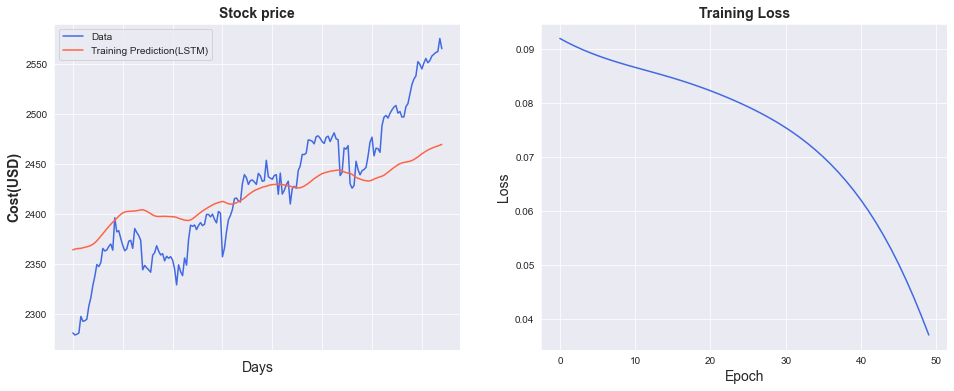

In [18]:
sns.set_style("darkgrid")

fig = plt.figure()
fig.subplots_adjust(hspace = 0.2, wspace=0.2)

plt.subplot(1,2,1)
ax = sns.lineplot(x= original.index, y= original[0], label='Data', color='royalblue')
ax = sns.lineplot(x= predict.index, y= predict[0], label='Training Prediction(LSTM)', color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel('Days', size = 14)
ax.set_ylabel('Cost(USD)', size = 14, fontweight='bold')
ax.set_xticklabels('', size = 10)

plt.subplot(1,2,2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size=14)
ax.set_ylabel("Loss", size=14)
ax.set_title("Training Loss", size = 14, fontweight = 'bold')
fig.set_figheight(6)
fig.set_figwidth(16)

In [19]:
from sklearn.metrics import r2_score

y_test_pred = model(x_test)

y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())  # Detach and then convert to NumPy
y_train = scaler.inverse_transform(y_train_lstm.detach().numpy())  # Detach and then convert to NumPy
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())  # Detach and then convert to NumPy
y_test = scaler.inverse_transform(y_test_lstm.detach().numpy())  # Detach and then convert to NumPy

trainR2 = r2_score(y_train[:, 0], y_train_pred[:, 0])
print('Train R-squared:', trainR2)
testR2 = r2_score(y_test[:, 0], y_test_pred[:, 0])
print('Test R-squared:', testR2)

lstm.append(trainR2)
lstm.append(testR2)
lstm.append(training_time)

Train R-squared: 0.5851373598091416
Test R-squared: -9.524194048897904
